In [2]:
#Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow as tf
import tqdm
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

In [4]:
#Menghitung banyak data sampah train organik
train_o = glob.glob(r'C:\Users\LENOVO\Downloads\DATASET\TRAIN\O\*.jpg')
a = len(train_o)

In [7]:
#Menghitung banyak data sampah train anorganik
train_r = glob.glob(r'C:\Users\LENOVO\Downloads\DATASET\TRAIN\R\*.jpg')
b = len(train_r)

In [9]:
print("Banyaknya sampel training: {}".format(a+b))

Banyaknya sampel training: 22564


In [2]:
#Mendefinisikan fungsi fungsi data yang akan diaugmentasi
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

NameError: name 'ImageDataGenerator' is not defined

In [1]:
#Mendefinisikan dataset training yang kemudian dilakukan augmentasi
train_dataset  = train_datagen.flow_from_directory(directory = r'C:\Users\LENOVO\Downloads\Bigdata_ricad\Testing',
                                                   target_size = (200,200),
                                                   class_mode = 'categorical',
                                                   batch_size = 128,
                                                   subset = 'training')

NameError: name 'train_datagen' is not defined

In [17]:
#Mendefinisikan dataset valid yang kemudian dilakukan augmentasi
valid_dataset = valid_datagen.flow_from_directory(directory = r'C:\Users\LENOVO\Downloads\DATASET\TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [18]:
#Mendefinisikan label (Class)
train_dataset.class_indices

{'O': 0, 'R': 1}

100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


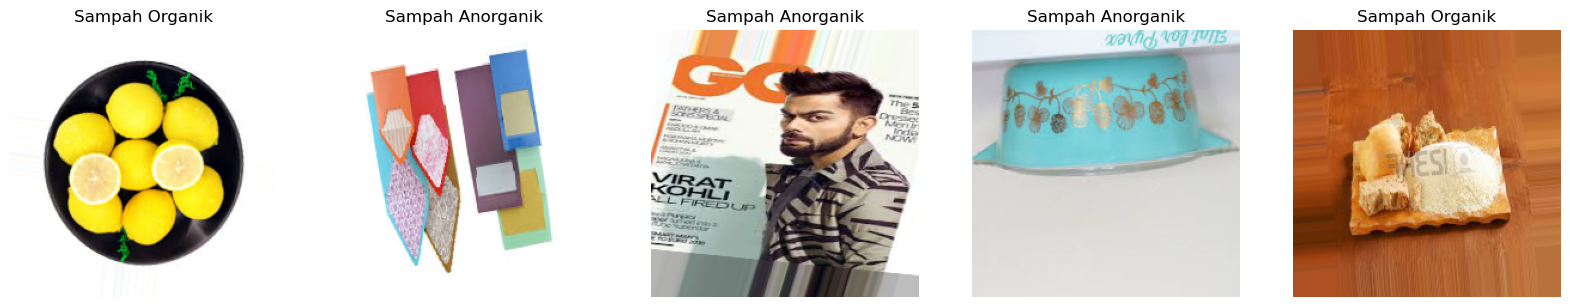

In [19]:
#Plot 5 gambar dari kedua label secara acak
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Sampah Anorganik')
    else:
        ax[i].set_title('Sampah Organik')

In [20]:
#Melakukan transfer learning menggunakan model pretrained MobileNetV2
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False, weights="imagenet")
#Membekukan bobot dari layer pretrained model
pretrained_model.trainable = False

9406464/9406464 [==============================] - 12s 1us/step


In [21]:
#Arsitektur MobilenetV2
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [22]:
#Mendefinisikan dan menambahkan layer untuk proses input dan output
model = tf.keras.Sequential()
model.add(pretrained_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [23]:
#Arsitektur model yang akan digunakan
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 batch_normalization (BatchN  (None, 62720)            250880    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              64226304  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4

In [24]:
#Menambahkan optimiser untuk mengurangi loss
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [25]:
#Mendefinisikan fungsi untuk callback dan checkpoint
filepath = r'C:\Users\LENOVO\Documents\training-model\model_terbaik.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [26]:
#Melatih model
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9040
Epoch 1: val_accuracy improved from -inf to 0.91356, saving model to C:\Users\LENOVO\Documents\training-model\model_terbaik.hdf5
142/142 [==============================] - 1124s 8s/step - loss: 0.2461 - accuracy: 0.9040 - val_loss: 0.2362 - val_accuracy: 0.9136
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9311
Epoch 2: val_accuracy improved from 0.91356 to 0.92863, saving model to C:\Users\LENOVO\Documents\training-model\model_terbaik.hdf5
142/142 [==============================] - 970s 7s/step - loss: 0.1797 - accuracy: 0.9311 - val_loss: 0.1933 - val_accuracy: 0.9286
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.9403
Epoch 3: val_accuracy improved from 0.92863 to 0.93240, saving model to C:\Users\LENOVO\Documents\training-model\model_terbaik.hdf5
142/142 [==============================] - 863s 6s/ste

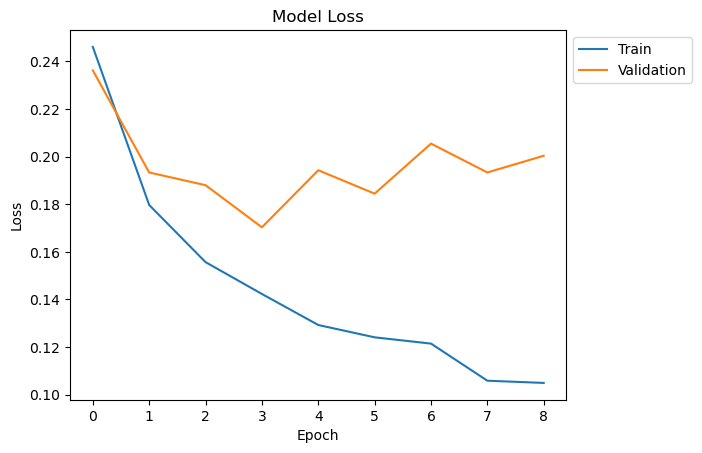

In [27]:
#Plot model loss selama pelatihan
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

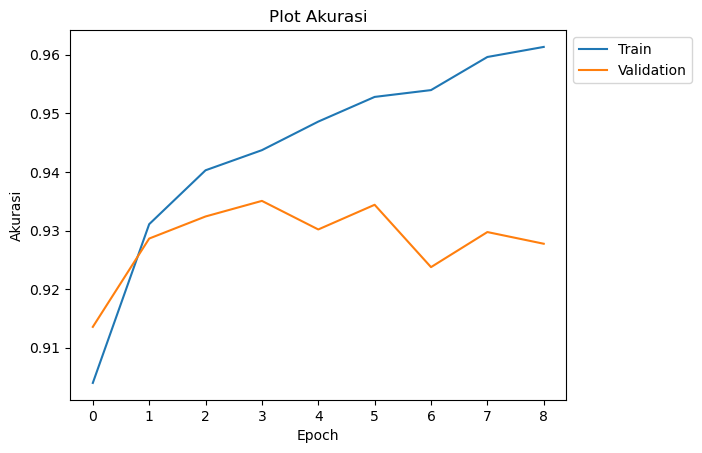

In [28]:
#Plot model accuracy selama pelatihan
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Plot Akurasi')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [29]:
#Melakukan test pada data baru
test_data = test_datagen.flow_from_directory(directory = r'C:\Users\LENOVO\Downloads\DATASET\TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [30]:
#Mengevaluasi model dengan data baru
model.evaluate(test_data)

20/20 [==============================] - 72s 3s/step - loss: 0.2773 - accuracy: 0.8953


[0.27726536989212036, 0.8953441977500916]

1/1 [==============================] - 2s 2s/step
Sampah Organik


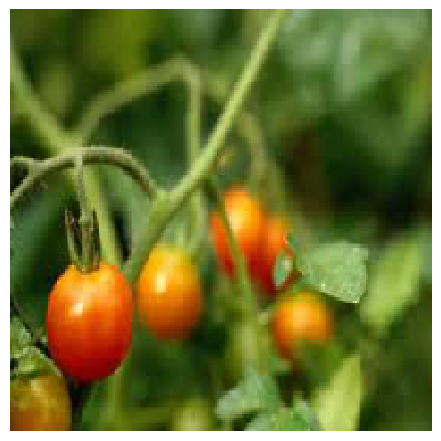

In [35]:
#Memprediksi model menggunakan data baru
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\LENOVO\Downloads\DATASET\TEST\O\O_13946.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

answer = model.predict(img)

if answer[0][0] > 0.5:
    print("Sampah Anorganik")
else:
    print("Sampah Organik")

1/1 [==============================] - 0s 78ms/step
Sampah Anorganik


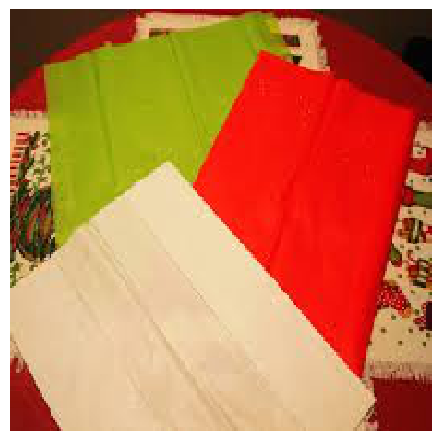

In [36]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(r'C:\Users\LENOVO\Downloads\DATASET\TEST\R\R_11094.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

answer = model.predict(img)

if answer[0][0] > 0.5:
    print("Sampah Anorganik")
else:
    print("Sampah Organik")